<a href="https://colab.research.google.com/github/Jotadebeese/Rubbish-Classifier-Updated/blob/main/paper_replicating/paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper Replicating

Turn a ML research paper into usable code. The [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) paper using PyTorch.

## 0. Setup

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the PyTorch Scripts directory, download it from GitHub
try:
    from modular_scripts import data_setup, engine, utils
except:
    # Get the scripts
    print("[INFO] Couldn't find scripts, downloading them from GitHub.")
    !git clone https://github.com/Jotadebeese/pytorch_scripts
    !mv pytorch_scripts/modular_scripts .
    !rm -rf pytorch_scripts
    from modular_scripts import data_setup, engine, utils

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find scripts, downloading them from GitHub.
Cloning into 'pytorch_scripts'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 257 (delta 6), reused 12 (delta 6), pack-reused 242
Receiving objects: 100% (257/257), 61.20 KiB | 10.20 MiB/s, done.
Resolving deltas: 100% (143/143), done.
[INFO] splitfolders module not found. Installing...


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1. Get Data and Data Preparation

In [4]:
from modular_scripts.utils import download_data

# Download the data
image_path = download_data(source='https://huggingface.co/datasets/Jotadebeese/rubbish_augmented/resolve/main/rubbish_dataset_augmented.zip?download=true',
                           destination='augmented_rubbish_dataset',
                           from_gdrive=False)

'data/augmented_rubbish_dataset' does not exist, creating directory...
[INFO] Downloading rubbish_dataset_augmented.zip?download=true from https://huggingface.co/datasets/Jotadebeese/rubbish_augmented/resolve/main/rubbish_dataset_augmented.zip?download=true...
[INFO] Unzipping rubbish_dataset_augmented.zip?download=true data...


In [5]:
utils.bulk_image_convertor(dataset_path=str(image_path) + '/rubbish_dataset_augmented',
                    format="jpg")

5674it [00:01, 3848.22it/s]


42 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/glass'


3274it [00:02, 1565.92it/s]


66 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/cardboard'


3692it [00:00, 164730.97it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/organic'


3156it [00:00, 170247.11it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/metal'


3042it [00:00, 151899.15it/s]


0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/plastic'


593it [00:03, 149.31it/s]


125 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/trash'


4228it [00:00, 172220.23it/s]

0 images converted to 'jpg' in 'data/augmented_rubbish_dataset/rubbish_dataset_augmented/paper'


In [6]:
train_dir, test_dir, val_dir = utils.split_data(
    input_folder=str(image_path) + '/rubbish_dataset_augmented',
    output_folder=image_path
)

Copying files: 23659 files [00:06, 3775.72 files/s]


In [7]:
train_dir, test_dir, val_dir

(PosixPath('data/augmented_rubbish_dataset/train'),
 PosixPath('data/augmented_rubbish_dataset/test'),
 PosixPath('data/augmented_rubbish_dataset/val'))

## 2. Create DataLoaders

In [8]:
from modular_scripts.data_setup import create_dataLoaders
from torchvision import transforms

# Create image size
IMG_SIZE = 224 # from ViT research paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

BATCH_SIZE = 32

# Create the dataloaders
train_dataLoader, test_dataLoader, class_names = create_dataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

print(f"Number of train images: {len(train_dataLoader.dataset)}, Train DataLoaders: {len(train_dataLoader)}")
print(f"Number of test images: {len(test_dataLoader.dataset)}, Test DataLoaders: {len(test_dataLoader)}")
print(f"Number of Classes: {len(class_names)}, Classes Names: {class_names}")

Number of train images: 18924, Train DataLoaders: 592
Number of test images: 2372, Test DataLoaders: 75
Number of Classes: 7, Classes Names: ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']


### 2.1 Visualize a single image

In [9]:
# Get the batch of images
image_batch, label_batch = next(iter(train_dataLoader))

# Get single image and label
image, label = image_batch[8], label_batch[8]

# Image shape and label
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

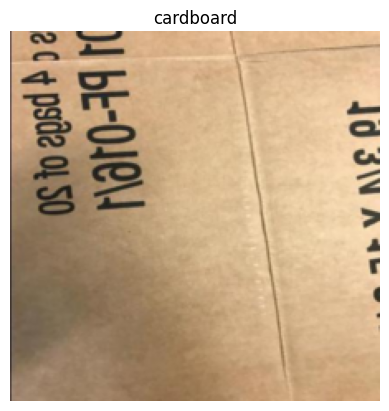

In [10]:
# Plot the Image with matplotlib

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

* **Inputs** - Images
* **Outputs** - Outside model/layer/block
* **Layers** - Takes an input and manipulates it with a function (equation)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

#### ViT Architecture

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/302ea8d0a64a52f33937084a7c0b9c5249d5f8f2/images/08-vit-paper-figure-1-architecture-overview.png' alt='ViT architecture' width='600px' />

#### ViT Equiations

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png' alt='equations' width='600px' />

### 3.1 Equations

**Equiation One:**
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

**Equation 2 & 3:**
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### 3.2 Model Variants and Parameters

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png' alt='table of the different ViT models, same architecture' width='600px' />

ViT-Base, ViT-Large and ViT-Huge are different sizes of the same model architecture.

* **ViT-B/16** = ViT-Base with image patch size 16x16
* **Layers** - the number of transformer encoder layers
* **Hidden size $D$** - the embedding size throughout the architecture
* **MLP size** - the number of hidden units/neurons in the MLP
* **Head** - the number of multi-head self-attention

## 4. Equation One: Split data into patches and create the class, position and patch embedding

Layers = input -> function -> output

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / P^2
* D = contant latent vector size = embedding dimension (See on Table 1)

In [11]:
# example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.1 Turning a single image into patches

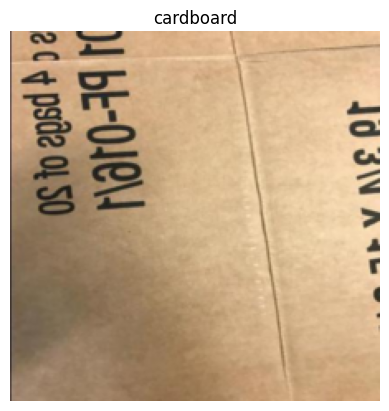

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

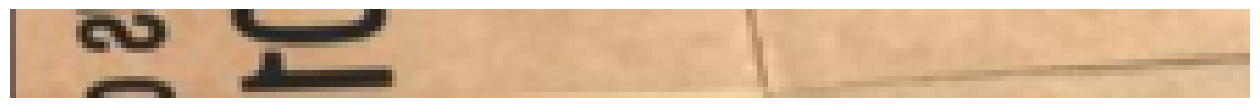

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


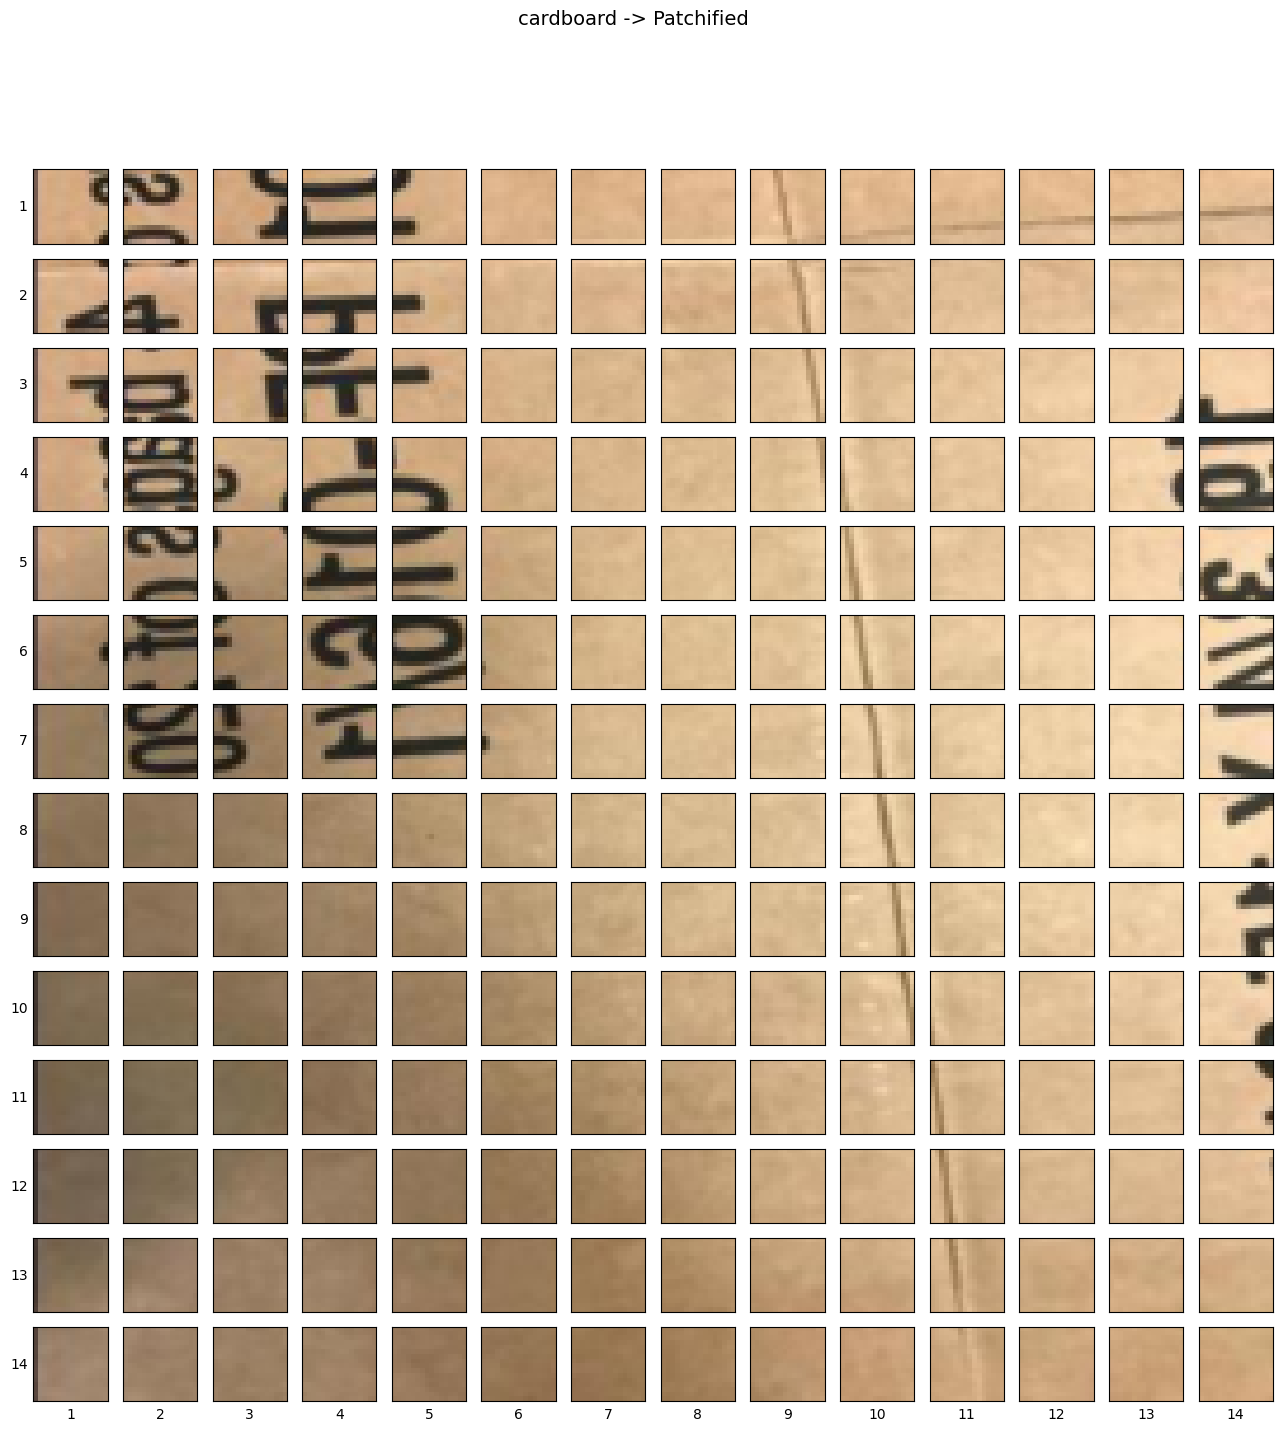

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = int(img_size/patch_size)
assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size"
print(f"Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal patches: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches, # One column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for j, patch_y in enumerate(range(0, img_size, patch_size)):
  for i, patch_x in enumerate(range(0, img_size, patch_size)):
      axs[j][i].imshow(image_permuted[patch_y:patch_y+patch_size, patch_x:patch_x+patch_size, :]);
      axs[j, i].set_ylabel(j+1, rotation="horizontal", horizontalalignment='right', verticalalignment='center')
      axs[j][i].set_xlabel(i+1)
      axs[j][i].set_xticks([])
      axs[j][i].set_yticks([])
      axs[j][i].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.2 Creating image patches and turning them into patch embeddings

By using `torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`.

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels=768, # D size from table 1,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [17]:
# Pass the image thrpught the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(f"{image_out_of_conv.shape} [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) [batch_size, embedding_dim, feature_map_height, feature_map_width]


Showing random convolution feature maps from indexes: [729, 471, 356, 668, 253]


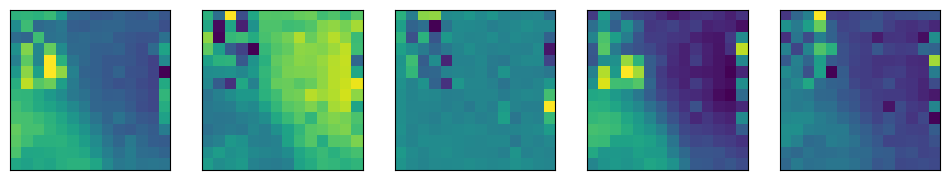

In [18]:
# plot ramdon convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolution feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy());
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


### 4.3 Flattening the patch embedding with `torch.nn.Flatten()`

In [19]:
print(f"{image_out_of_conv.shape} [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) [batch_size, embedding_dim, feature_map_height, feature_map_width]


In [20]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


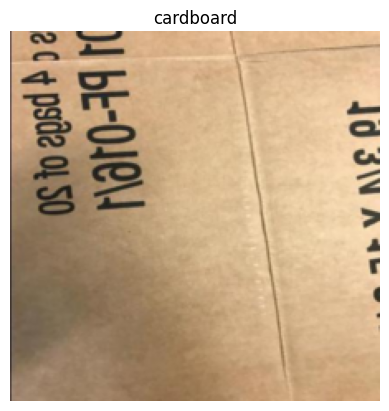

In [21]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape: {image.shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [22]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embeding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embeding_dimension)


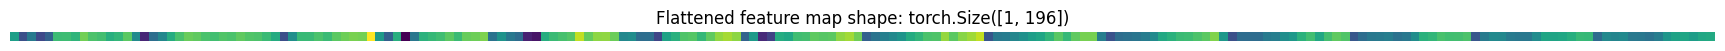

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy());
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.4 Turning the ViT patch embedding layer into a PyTorch module

In [24]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               patch_size:int=16,
               in_channels:int=3,
               embedding_dim:int=768): # from Table 1 for ViT-Base
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patcher.stride[0] == 0, f"Image resolution must be divisible by patch size, image shape: {image_resolution}, patch_size: {self.patch_size}"
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0, 2, 1)

In [25]:
from modular_scripts.utils import set_seeds

set_seeds(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(patch_size=16, in_channels=3, embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
path_embedded_image = patchify(image.unsqueeze(0)) # Add an extra batch dimension
print(f"Output patch embedding sequence shape: {path_embedded_image.shape}")


Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


### 4.5 Class token embedding

In [26]:
# Batch size and embedding dimension
batch_size, embedding_dim = path_embedded_image.shape[0], path_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [27]:
# Class token embedding
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim))
class_token.shape

torch.Size([1, 1, 768])

In [28]:
# Add the class_token to the fron of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat([class_token, path_embedded_image], dim=1)
print(f"Sequence of patch embeddings with class token prepended shape:\n{patch_embedded_image_with_class_embedding.shape} -> [batch_size, class_token + number_of_patches, embedding_dim]")

Sequence of patch embeddings with class token prepended shape:
torch.Size([1, 197, 768]) -> [batch_size, class_token + number_of_patches, embedding_dim]


### 4.6 Creating the position embedding

In [29]:
# Calculate N (number of patches)
number_of_patches = int(height * width / patch_size ** 2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                              number_of_patches + 1,
                                              embedding_dimension),
                                  requires_grad=True)
position_embedding.shape

torch.Size([1, 197, 768])

In [30]:
# Add position embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

### 4.6 Putting it all together: from image to embedding

In [31]:
# set seeds
set_seeds()

path_size = 16
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0) # Add batch dimension

patch_embedding_layer = PatchEmbedding(in_channels=3, embedding_dim=768, patch_size=patch_size) # patch embeding layer
patch_embedding  = patch_embedding_layer(x) # input throught PatchEmbedding

# Create class token em,bedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension))

# Add class token to patch embedding
patch_embedding_class_token = torch.cat([class_token, patch_embedding], dim=1)

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension), requires_grad=True)

# Add position embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: MSA

In [32]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block (MSA)
  """

  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()
    # Create the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    x, _ = self.multihead_attn(query=x,
                               key=x,
                               value=x,
                               need_weights=False)
    return x

In [33]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence througth MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: MLP

In [34]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [35]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the mSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Transformer Encoder

### 7.1 Custom transformer encoder block

In [36]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
  def forward(self, x):
    x = x + self.msa_block(x)
    x = x + self.mlp_block(x)
    return x

In [37]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a sumary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Transformer Encoder Layer with in-built PyTorch layers

In [38]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

In [39]:
# Get a sumary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. All together

In [40]:
# Create ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    self.num_patches = (img_size * img_size) // patch_size**2
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                             patch_size=patch_size,
                                             embedding_dim=embedding_dim)
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                        num_heads=num_heads,
                                                                        mlp_size=mlp_size,
                                                                        mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )
  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)
    x = x + self.position_embedding
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x



In [41]:
set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.0738,  0.8628,  1.6092, -0.5190, -0.0674,  0.1514, -0.4814]],
       grad_fn=<AddmmBackward0>)

### 8.1 Visual summary of ViT

In [42]:
from torchinfo import summary

summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 7]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

##9. Training code for custom ViT

### 9.1 Optimizer

In [43]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Loss function

In [44]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training ViT model

In [47]:
from modular_scripts.engine import train

set_seeds()

#results = train(model=vit,
              #  train_dataloader=train_dataLoader,
                #test_dataloader=test_dataLoader,
                #epochs=10,
                #optimizer=optimizer,
                #loss_fn=loss_fn,
                #device=device)

'results = train(model=vit,\n                train_dataloader=train_dataLoader,\n                test_dataloader=test_dataLoader,\n                epochs=10,\n                optimizer=optimizer,\n                loss_fn=loss_fn,\n                device=device)'

In [51]:
from modular_scripts.utils import plot_loss_curves

#plot_results(results)